In [1]:
# PACKAGE IMPORT
import numpy as np
import scipy as sp
import math
import pandas as pd
import ne2001.density
from pandas import DataFrame as df
import sklearn
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import signal
from frb import igm
from frb import mw
from sklearn.neighbors import KernelDensity
import random
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns

sns.set()
sns.set_style('darkgrid')
sns.set_context('poster')

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

print('PACKAGES IMPORTED')

PACKAGES IMPORTED


We wish to find the dispersion measure (DM) of an FRB host galaxy ($DM_{host}$), the IGM in front of the FRB ($DM_{cosmic}$) and of the Milky Way halo ($DM_{MWhalo}$).

$DM_{host}$ for now is just sampled from a lognormal distribution. For $DM_{MWhalo}$ we use a very narrow Gaussian.

$DM_{cosmic}$ is a function of redshift $z$, and thus we first create a distribution for $z$.

The FRB redshift distribution, which is assumed to be related to the star formation rate (SFR) and is given by

$$\psi(z) = K\Psi(z)^n, $$

where $n=1$ corresponds to an evolutionary history that's linearly proportional to the SFR (type 1 stars) and $n=2$ corresponds to events whose progenitors might involve two stars that formed independently (type 2 stars). $K$ is a proportionality constant. $\Psi(z)$ is the cosmic star formation rate, given by

$$\Psi(z) = 0.015\frac{(1+z)^{2.7}}{1+[(1+z)/2.9]^{5.6}} \text{M}_\odot \text{y}^{-1} \text{Mpc}^{-3}.$$

The FRB rate per unit volume depends on the product of $\Psi(z)$'s for type 1 and type 2 stars multiplied by an interaction cross-section, $\sigma_{12}$.

$$\text{FRB rate density[events y}^{-1}\text{Mpc}^{-3}] = \sigma_{12}[A_1\psi(z_{type 1})][A_2\psi(z_{type 2})]$$

The number of events per redshift bin is
$$ n_{events} \propto \text{FRB rate density}\times V_{area} \text{[events y}^{-1}], $$
where $V_{area}$ is the volume of the shell defined by $V_{z_n}-V_{z_{n-1}}$, where $z_n - z_{n-1}=\Delta z$, our redshift bins. 
 


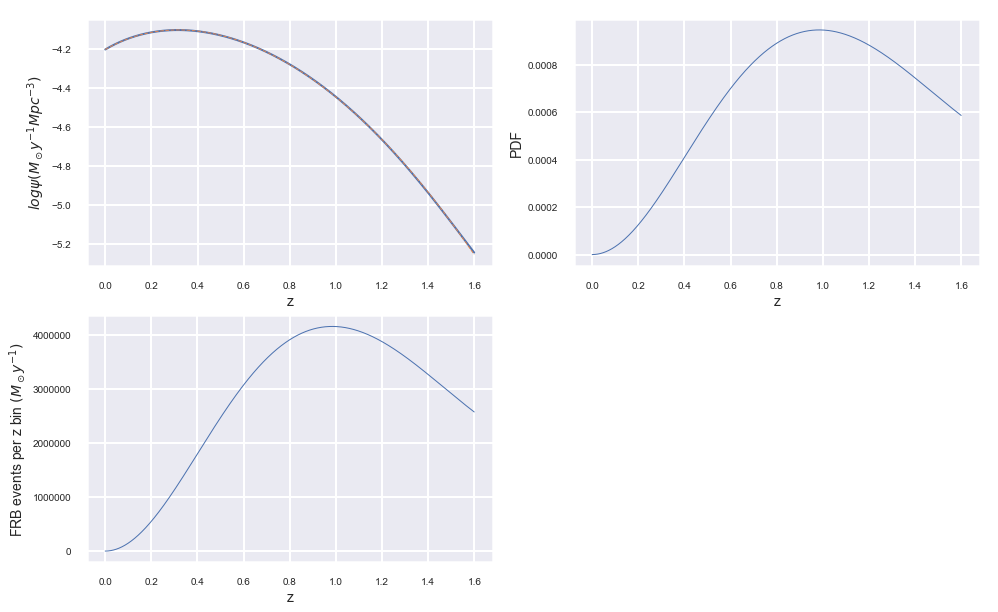

In [2]:
#!!make sure cut off at ~1, cut off with exp(-z/0.5) or the like
#!!rate out by factor of log(2)

#Mpc
cutoff_value = 0.8
max_z = cutoff_value*2
z_stepsize = 0.001
z = np.arange(0,max_z,z_stepsize)
z_obs_cutoff = np.int(list(z).index(cutoff_value))
Mpc = cosmo.comoving_distance(z).value 
# plt.plot(z,Mpc)
Mpc_stepsize = cosmo.comoving_distance(z_stepsize).value

psi = 0.015*(1+z)**2.7/(1+((1+z)/2.9)**5.6) #star formation rate density
# psi_cutoff = psi

# psi_SFR = psi[:z_obs_cutoff]
# psi_cutoff = psi_cutoff[z_obs_cutoff:]

# FRB_rate_density = np.append(psi_SFR,psi_cutoff)
FRB_rate_density = psi*np.exp(-z/0.5)
FRB_density_smooth_ = sp.interpolate.UnivariateSpline(z, FRB_rate_density, s=0.001)
FRB_density_smooth = FRB_density_smooth_(z)

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(221)
ax1 = plt.plot(z,np.log(FRB_density_smooth),lw=2)
ax1 = plt.plot(z,np.log(FRB_rate_density),lw=1,linestyle='dashed')
ax1 = plt.xlabel('z', fontsize=14)
ax1 = plt.ylabel(r'$log \psi(M_\odot y^{-1} Mpc^{-3})$', fontsize=14)

V_sphere = 4/3*np.pi*Mpc**3
V_shell = [y - x for x,y in zip(V_sphere,V_sphere[1:])]

FRB_events_per_z_bin = FRB_density_smooth[1:]*V_shell

#normalize so that becomes PDF sums to 1
FRB_events_normalized = FRB_events_per_z_bin/sum(FRB_events_per_z_bin)

ax2 = fig.add_subplot(222)
ax2 = plt.plot(z[1:], FRB_events_normalized,lw=1)
ax2 = plt.xlabel('z', fontsize=14)
ax2 = plt.ylabel('PDF', fontsize=14)

ax3 = fig.add_subplot(223)
ax3 = plt.plot(z[1:], FRB_events_per_z_bin,lw=1)
ax3 = plt.xlabel('z', fontsize=14)
ax3 = plt.ylabel(r'FRB events per z bin $(M_\odot y^{-1})$', fontsize=14)

# plt.plot(Mpc[1:],FRB_events_normalized)

# print(sum(FRB_events_normalized))

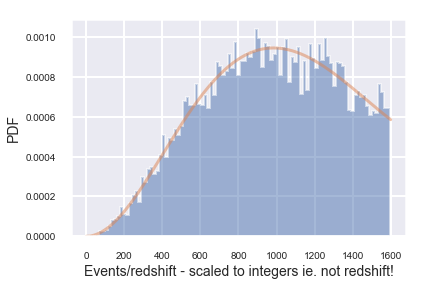

In [12]:
#Make custom PDF with the event rate distribution
#Here we have our distribution given by a function, so we need to create a PDF from this using rv_discrete

x_z = np.arange(len(z[1:])) #! for .rv_discrete to work, we have to have x_z as integers -> need to scale back later
event_pdf = FRB_events_normalized

custom_z_pdf = sp.stats.rv_discrete(name='Custom z pdf', values=(x_z, event_pdf))

event_draws = custom_z_pdf.rvs(size=10000)
event_hist = plt.hist(event_draws, density=True, bins=100, histtype='stepfilled', alpha=0.5)
plt.plot(z[1:]*1/z_stepsize,FRB_events_normalized, alpha=0.5)
plt.xlabel('Events/redshift - scaled to integers ie. not redshift!', fontsize=14)
plt.ylabel('PDF', fontsize=14)

z_cosmic_draws = event_draws*z_stepsize #rescaling back to correct redshift

We use igm.average_DM to calculate the average $DM_{cosmic}$. It takes a while, so fit a spline to draw from. This is then used to find the variance:

$$\frac{\sigma_{DM}}{DM_{average}} = Fz^{-0.5} $$
where $\sigma$ is the variance and $F=0.2$.

We then sample from a Guassian again, with $\sigma_{DM}$. Combine $DM_{cosmic}$ and $DM_{host}$. Draw 10 samples and use to build KDE, and see how it compares to the original distribution.

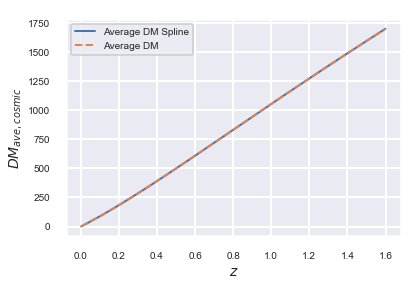

In [13]:
#Calculate average DM using X's frb package
DM_ave_fn = igm.average_DM(max_z, cosmo=None, cumul=True, neval=1000, mu=1.3) #up to redshift 2
DM_ave_ = DM_ave_fn[0].value
z_ave = DM_ave_fn[1]

#Approximate average DM with spline
DM_int_ave = sp.interpolate.CubicSpline(z_ave,DM_ave_)

ax1 = plt.plot(z_ave,DM_int_ave(z_ave),lw=2,label='Average DM Spline')
ax2 = plt.plot(z_ave, DM_ave_,lw=2,linestyle='dashed',label='Average DM')
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$DM_{ave,cosmic}$', fontsize=14)
plt.legend(loc=2, prop={'size': 10})

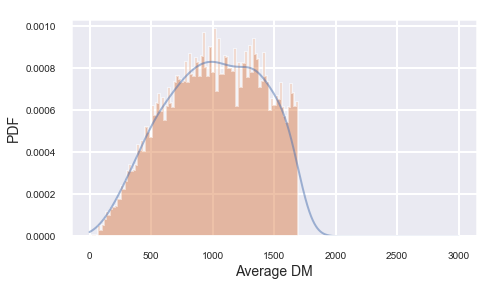

In [14]:
#Create histogram of DM_ave using the FRB events/redshift distribution: z_cosmic

#make spline for efficiency
DM_ave = DM_int_ave(z_cosmic_draws)

#Fit pdf to DM_ave histogram using kde
DM_grid_ave = np.arange(0,3000,1)
kde_skl_ave = KernelDensity(bandwidth=100,kernel='gaussian')
kde_skl_ave.fit(DM_ave[:, np.newaxis])
log_pdf_ave = kde_skl_ave.score_samples(DM_grid_ave[:, np.newaxis])
DM_pdf_ave = np.exp(log_pdf_ave)
#choose floor 5 sigma or the like
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1 = plt.plot(DM_grid_ave, DM_pdf_ave, linewidth=2, alpha=0.5)
ax1 = plt.hist(DM_ave, density=True, bins=100, histtype='stepfilled', alpha=0.5)
ax1 = plt.xlabel('Average DM', fontsize=14)
ax1 = plt.ylabel('PDF', fontsize=14)

In [20]:
F = 0.2
sigma_DM = DM_ave*F*z_cosmic_draws**(-0.5) 

DM_cos = DM_ave + DM_ave*np.random.normal(loc = 0.0, scale = 0.1, size = 10000)

# plt.plot(DM_pdf_ave)

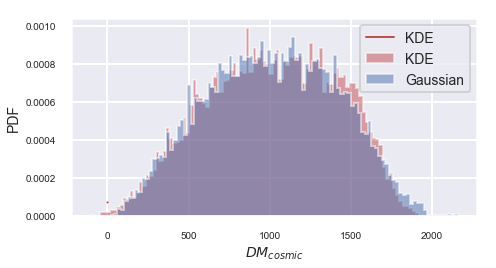

In [21]:
#From this we get our DM_ave at each point (mean value) and then our variance (sigma) at each point

z_grid_DM = np.linspace(0, max_z, num=10000) #redshift range

F = 0.2
# sigma_DM = DM_ave*F*z_cosmic_draws**(-0.5) #cap
# DM_cos_gauss = DM_ave+norm.rvs(10000)*sigma_DM

#For kde, the bandwith can be obtained from the DM variance
bandwidth_DM = 200. #1.06*sigma_DM*(np.size(z_cosmic_draws))**(-1/5) #bandwidth = 1.06*sigma*n^(-1/5)

#KDE
DM_cosmic_draws_kde = kde_skl_ave.sample(10000).flatten() #sampled from DM_ave fit
kde_skl_DM = KernelDensity(bandwidth=bandwidth_DM,kernel='gaussian')
kde_skl_DM.fit(DM_cosmic_draws_kde[:, np.newaxis])
log_pdf_DM = kde_skl_DM.score_samples(z_grid_DM[:, np.newaxis])
pdf_DM_kde = np.exp(log_pdf_DM)

fig = plt.figure(figsize=(16,8))


#Histograms and PDFs
ax1 = fig.add_subplot(221)
#KDE
ax1 = plt.hist(DM_cosmic_draws_kde, density=True, bins=100, histtype='stepfilled', alpha=0.5, label='KDE',color='r')
ax1 = plt.plot(z_grid_DM, pdf_DM_kde, linewidth=2, alpha=1, label=r'KDE', color='r')
#Gauss
ax1 = plt.hist(DM_cos, density=True, bins=100, histtype='stepfilled', alpha=0.5, label='Gaussian',color='b')
# ax1 = plt.plot(z_grid_DM, pdf_DM_gauss, linewidth=2, alpha=0.1, label='Gaussian', color='b')
#Axes
ax1 = plt.xlabel(r'$DM_{cosmic}$',fontsize=14)
ax1 = plt.ylabel('PDF', fontsize=14)
ax1 = plt.legend(fontsize=14)

#!! 2 sigma

0.9998103266049044


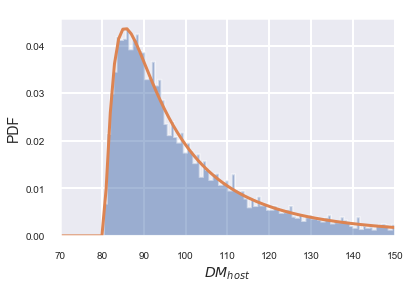

In [22]:
#DM_host is straight forward - we just sample from a lognormal distribution
"lognorm.pdf(x, s, loc, scale), s (shape) is std dev, loc is mean, scale is by hand"
mu_hostDM = 80.             #mean host DM (x)
sigma_hostDM = 1.          #variance/std dev of host DM (s)

DM_host = lognorm(sigma_hostDM, loc=mu_hostDM, scale=15).rvs(size=10000)
params_host = lognorm.fit(DM_host)

x_host = np.arange(500) #redshift range of interest
pdf_host_fitted = lognorm.pdf(x_host, params_host[0], loc=params_host[1], scale=params_host[2])
x_host_fitted = np.arange(len(pdf_host_fitted))

ax1 = plt.hist(DM_host, density=True, bins=1000, histtype='stepfilled', alpha=0.5)
ax2 = plt.plot(x_host_fitted,pdf_host_fitted)
plt.xlabel('$DM_{host}$', fontsize=14)
plt.ylabel('PDF', fontsize=14)
plt.xlim(70,150)
print(sp.integrate.trapz(pdf_host_fitted,x_host))

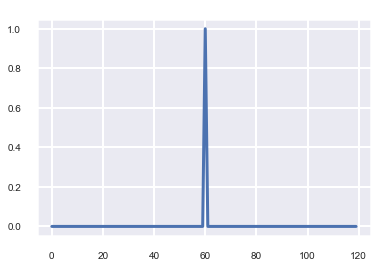

In [23]:
#DM_host is straight forward - we just sample from a normal distribution
mu_MWhalo = 60 #mean MW halo DM (x)
DM_MWhalo = mu_MWhalo
# DM_np.arange(-50, 50)
imp = signal.unit_impulse(mu_MWhalo*2,'mid') #impulse
plt.plot(np.arange(len(imp)),imp)

#optimal kde to give highest precision of gap
# to estimate make PDF of DM_gaps with lots of different draws

Text(0, 0.5, '$DM_{cosmic}+DM_{host}$')

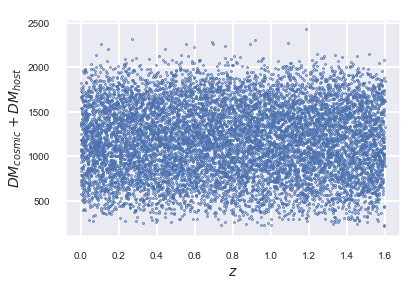

In [26]:
#Plot DM_cosmic + DM_host vs redshift
DM_full = DM_host+DM_cos+DM_MWhalo

##DM_MWhalo at redshift??

plt.scatter(z_grid_DM,DM_full,s=0.5)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$DM_{cosmic}+DM_{host}$', fontsize=14)
# print(min(DM_full))

Text(0, 0.5, 'PDF')

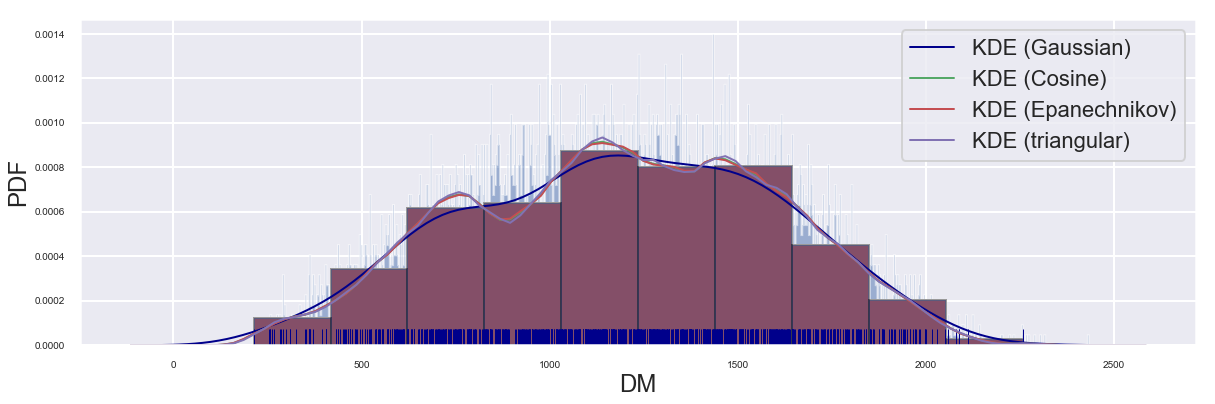

In [31]:
plt.figure(figsize=(20,6))

ax1 = plt.hist(DM_full, density=True, bins=1000, histtype='stepfilled', alpha=0.5)

rand_DM = np.random.choice(DM_full,1000)
# print(plt.hist(rand_DM,density=True,bins=10))
counts,bins,edges = plt.hist(rand_DM,density=True,bins=10)
rand_DM_array = np.dstack((bins[:-1],counts))


ax2 = sns.distplot(rand_DM, kde=True,rug=True, hist=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,'label':'KDE (Gaussian)'}) #just because this plots the histogram nicely

ax2 = sns.kdeplot(rand_DM,kernel='cos',label='KDE (Cosine)',linewidth=2)
ax4 = sns.kdeplot(rand_DM,kernel='epa',label='KDE (Epanechnikov)',linewidth=2)
ax5 = sns.kdeplot(rand_DM,kernel='tri', label='KDE (triangular)',linewidth=2)

plt.xlabel('DM')
plt.ylabel('PDF')

In [ ]:
#Let's try constrain the DM gap
DM_gap = DM_MWhalo+min(DM_full)
print(DM_gap)

#do this for lots of draws and for a few draws
#use KDE to approximate